**Demonstrate the operations of the Adaptive Notch Filter**

In [1]:
%matplotlib notebook

# Load the required libraries
import numpy as np

from scipy import signal
from scipy.fft import fftshift

import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipyfilechooser import FileChooser
from IPython.display import display

import adaptivenotch as anf

**Define the signal characteristics**

In [2]:
signal_char = {
               "fs" : 10e6,          # Sampling frequency
               "fi" : 0.0e6,         # Intermediate frequency
              }

isComplex = True   # Tell if the samples are in I/Q format
is16Bits  = False  # Tell if the samples are stored on 16 bits/byte
isRtl = False      # Tell if the data were collected using an RTl-SDR dongle

**Open the input file and read the data**

In [3]:
# Create and display a FileChooser widget
fc = FileChooser()
display(fc)

FileChooser(path='/home/daniele/Documents/Projects/2021/Jamming demo', filename='', title='HTML(value='', layo…

In [4]:
filename = fc.selected
if filename is None :
    filename = "./data/JammerData.bin"
    
#open the binary file
fid = open(filename,'rb');

secondOfData = 1e-4 # 100 mu seconds
N = np.int(np.floor( secondOfData * signal_char["fs"] ))

if isComplex :
    if is16Bits :    
        data = np.fromfile(fid, dtype = np.int16, count = 2 * N )
    else :
        if isRtl :
            data = np.fromfile(fid, dtype = np.uint8, count = 2 * N )
            data = data.astype(dtype = np.int8) - 127
        else :
            data = np.fromfile(fid, dtype = np.int8, count = 2 * N )
    data = data[::2] + 1j*data[1::2]
else:
    if is16Bits :    
        data = np.fromfile(fid, dtype = np.int16, count = N )
    else :
        data = np.fromfile(fid, dtype = np.int8, count = N )

**Create the Adaptive Notch Filter (ANF)**

In [5]:
notch = anf.adaptivenotch(0.8, 0.05)
y, z0 = notch.filter( data )

<IPython.core.display.Javascript object>


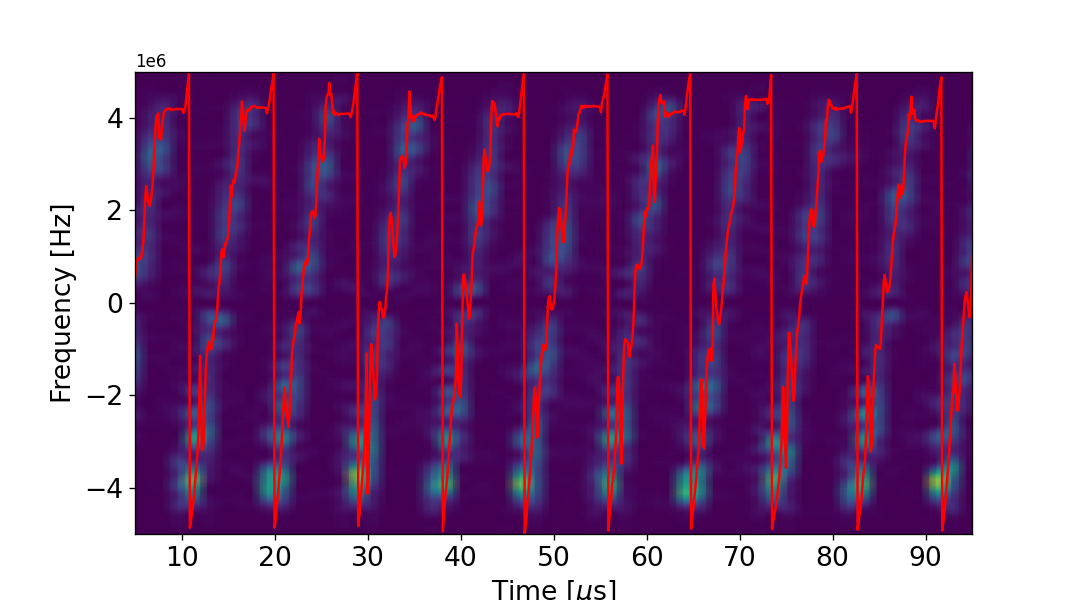

interactive(children=(FloatSlider(value=0.9, description='ka', max=0.99, step=0.01), FloatSlider(value=0.01, d…

<function __main__.update(ka, mu)>

In [6]:
f, t, Sxx = signal.spectrogram(data, nfft = 1024, nperseg = 32, noverlap = 16, 
                               fs = signal_char["fs"], return_onesided = False )

# Create the interactive figure
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(9, 5)
ax.pcolormesh(t * 1e6, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
ax.set_ylabel('Frequency [Hz]', fontsize = 16)
ax.set_xlabel('Time [$\mu$s]', fontsize = 16)
ax.tick_params(labelsize=16)

line, = ax.plot(np.arange(0,len(data)) / signal_char["fs"] * 1e6,
                 signal_char["fs"] * np.angle(z0) / (2 * np.pi), 'r')
ax.set_xlim([5, 95])

def update(ka, mu) :

    # filter the data
    notch = anf.adaptivenotch(ka, mu)
    y, z0 = notch.filter( data )
    
    print("ka = %f" % ka)
        
    line.set_ydata( signal_char["fs"] * np.angle(z0) / (2 * np.pi) )
    fig.canvas.draw_idle()
    
widgets.interact(update, ka = widgets.FloatSlider(value=0.9, min=0, max=0.99, step = 0.01, description='ka'),
                 mu = widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step = 0.01, description='$\delta$'))

In [7]:
import ipyvolume as ipv
from matplotlib import cm

f, t, Syy = signal.spectrogram(y, nfft = 1024, nperseg = 32, noverlap = 16, 
                               fs = signal_char["fs"], return_onesided = False )

ipv.figure(width=800, height=500)
T, F = np.meshgrid(t * 1e6, fftshift(f))
Z = fftshift(Syy, axes=0) / Sxx.max()
colormap = cm.coolwarm
color = colormap(Z)

ipv.plot_surface(T, Z, F, color = color)
ipv.show()